1.1:
- States: All possible board states
- Actions: Move any piece on any field
- Reward dynamics: Deterministic
  - illegal move: -∞
  - getCheckmated: -100
  - Checkmate: 100
  - else: sum of own piece values - sum of opponents piece values
- State dynamics: Deterministic

Policy formalization: 
Go through all actions and choose action with hightest reward. If some actions have equal rewards, pick from these actions with unifrom probability distribution

1.2:
According to https://www.gymlibrary.dev/environments/box2d/lunar_lander/ , the environment is described as follows:
- Actions = {do nothing, fire left orientation engine, fire main engine, fire right orientation engine}
- States: 8-dimensional vector: coordinates of the lander (x, y), linear velocities (x, y), angle, angular velocity, left leg on ground, right leg on ground
- Reward-dynamics: Quoted from above: Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.
- state-dynamics: Deterministic, determined through the Box2D physics

Policy formalization: heuristic defined in https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py : \
a = 0 \
if hover_todo > np.abs(angle_todo) and hover_todo > 0.05: \
&nbsp;&nbsp;&nbsp;&nbsp; a = 2 \
elif angle_todo < -0.05: \
&nbsp;&nbsp;&nbsp;&nbsp; a = 3 \
elif angle_todo > +0.05: \
&nbsp;&nbsp;&nbsp;&nbsp; a = 1 \
with 1 = Nop, 2 = fire left engine, 3 = main engine, 4 = right engine and hover_todo and angle_todo are the hover/ angle we aim to have (these are calculated according to our current state; hover should be steadily decreasing and angle should be between -0.4, 0.4)

The environment dynamics are a probibility distribuition p(s', r | s, a). They are the the joint probability distribution over the state and reward dynamics. The state transition function (state dynamcis) gives the probability of ending up in a certain state after choosing a specified action in a specified state. The reward function (reward dynamics) gives the probability of getting a certain reward after performing a specified action in a specified state.
Examples for the state dynamics are
- Physics in Real Life tasks
- Behaviour of a video game \

Examples for the reward dynamics are
- Loss/ Gain of money in a casino game
- Points in a video game

The environment dynamics are not generally known and cannot generally be practically used to solve a RL problem. Take the example of a self driving car. The state dynamics would have to include the behaviour of other cars. But their behaviour is obviously not known.

Examples: \
    - https://agentmodels.org/chapters/3b-mdp-gridworld.html \
    - https://cs.stanford.edu/people/karpathy/reinforcejs/gridworld_td.html \
    - https://codehs.com/sandbox/apcsa/gridworld

In [58]:

import numpy as np
import itertools
from matplotlib import pyplot as plt
from matplotlib import colors


# Actions
LEFT = (0,-1)
RIGHT = (0,1)
TOP = (-1,0)
DOWN = (1,0)
# Action Names (used for plotting)
action_names = { 
    LEFT: "←",
    RIGHT: "→",
    TOP: "↑",
    DOWN: "↓"
}


class GridWorld():
    def __init__(self, size, goal):
        self.size = size
        self.states = list(np.ndindex(size))
        self.rewards = dict(zip(self.states, itertools.repeat(-0.1)))
        self.rewards[goal] = 1
        self.goal = goal
        self.actions = [LEFT, RIGHT, TOP, DOWN]
        #initialize deterministic policy
        self.dynamics = {start: {action: {tuple(np.add(start,action)): 1} for action in self.actions} for start in self.states}
        for x in range(size[1]):
            self.dynamics[(0,x)][TOP] = {(0,x): 1}
            self.dynamics[(size[0]-1,x)][DOWN] = {(size[0]-1,x): 1}
        for x in range(size[0]):
            self.dynamics[(x,0)][LEFT] = {(x,0): 1}
            self.dynamics[(x,size[1]-1)][RIGHT] = {(x,size[1]-1): 1}
        self.specialTiles = {}
        self.reset()
        
    def addTrap(self, coordinates):
        self.rewards[coordinates] = -1
    
    def addWall(self, coordinates):
        for action in self.actions:
            neighbour = tuple(np.add(coordinates, action))
            if neighbour in self.states:
                for action in self.dynamics[neighbour]:
                    if coordinates in self.dynamics[neighbour][action]:
                        p = self.dynamics[neighbour][action][coordinates]
                        self.dynamics[neighbour][action][coordinates] = 0
                        self.dynamics[neighbour][action][neighbour] = p
        self.rewards[coordinates] = -1
        self.specialTiles[coordinates] = 'wall'
        
    def addSlider(self, from_tile, to_tile):
        for action in self.actions:
            self.dynamics[from_tile][action] = {to_tile: 1}
        self.specialTiles[from_tile] = 'slider'
     
    def reset(self):
        self.state = random.choice(self.states)
        #self.reward = 0
        
    def step(self, action):
        #self.state = tuple(np.add(self.state, action))
        dyn = self.dynamics[self.state][action]
        self.state = random.choices(population = list(dyn.keys()), weights = list(dyn.values()))[0]
        #self.reward += self.rewards[self.state]
        return self.rewards[self.state]
        
    def gameOver(self):
        return self.state == self.goal or self.rewards[self.state] <= -1 #or self.reward <= -1
    
    def getState(self):
        return self.state
    def getGoal(self):
        return self.goal
    def getActions(self):
        return self.actions
    def getReward(self, state):
        return self.rewards[state]
    def getStates(self):
        return self.states
    
    def plot(self, labels):
        fig, ax = plt.subplots()
        field = np.reshape(list(self.rewards.values()), self.size)
        for tile, tile_type in self.specialTiles.items():
            if tile_type == "wall":
                field[tile[0]][tile[1]] = 10
            elif tile_type == "slider":
                field[tile[0]][tile[1]] = -10
        ax.imshow(field)
        for pos, val in labels.items():
            if isinstance(val, str):
                ax.text(pos[1], pos[0], val, ha='center', va='center',size=12)
            else:
                ax.text(pos[1], pos[0], '{:.3f}'.format(val), ha='center', va='center',size=12)
        plt.show()

In [59]:
import random

def naive_pi(world):
    distances = {action: np.linalg.norm(np.subtract(tuple(np.add(world.getState(), action)), world.getGoal())) for action in world.getActions()}
    #print((tuple(np.add(world.getState(), TOP)), world.getGoal()))
    
    #print(distances)
    
    
    minim = min(distances, key = distances.get)
    for x in distances:
        distances[x] = 0.2 / (len(distances)-1)
    distances[minim] = 0.8
    return random.choices(population = list(distances.keys()), weights = list(distances.values()))[0]

In [60]:
world = GridWorld((5,7), (4,6))
world.addTrap((3,3))
world.addTrap((4,1))
world.addTrap((3,0))
world.addSlider((3,4), (3,3))
#important: add Walls after sliders!
world.addWall((3,6))
world.addWall((3,5))
print(world.dynamics[(3,5)])

{(0, -1): {(3, 4): 1}, (0, 1): {(3, 6): 0, (3, 5): 1}, (-1, 0): {(2, 5): 1}, (1, 0): {(4, 5): 1}}


(0, 1)


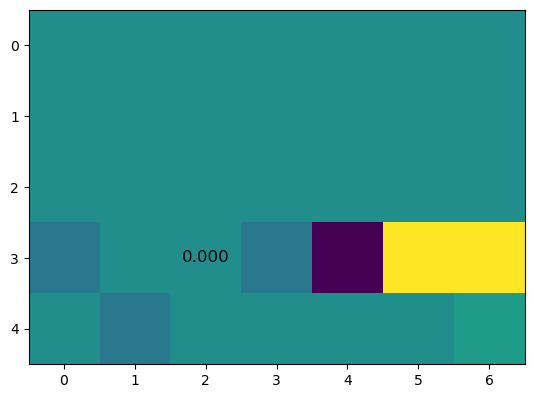

(0, 1)


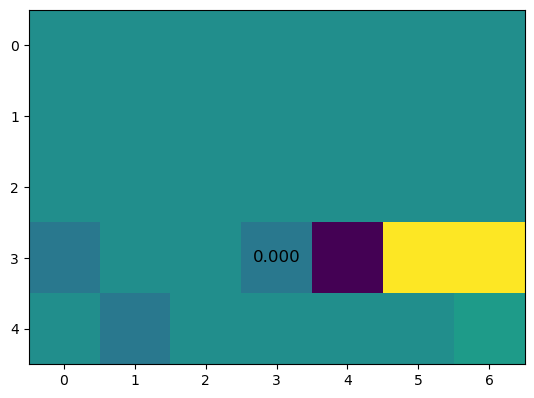

(0, 1)


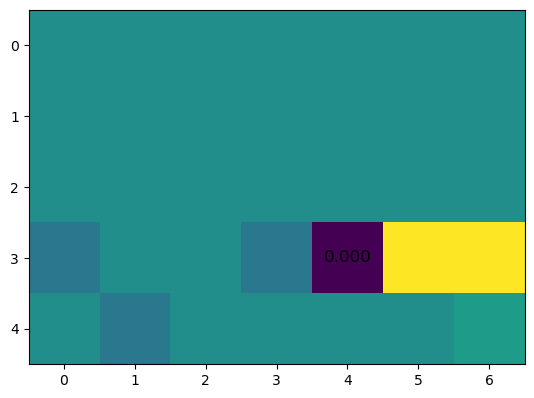

(0, 1)


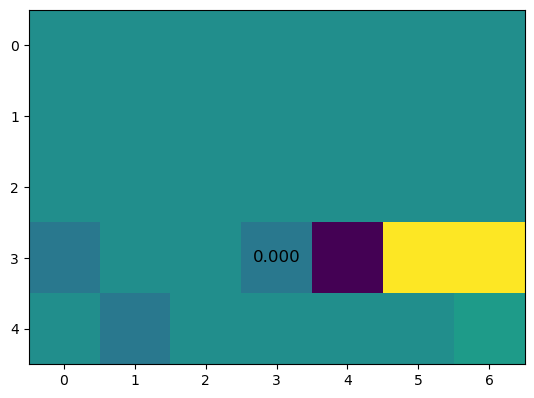

(1, 0)


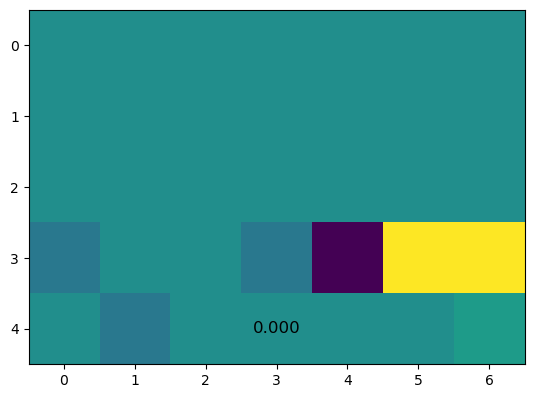

(0, 1)


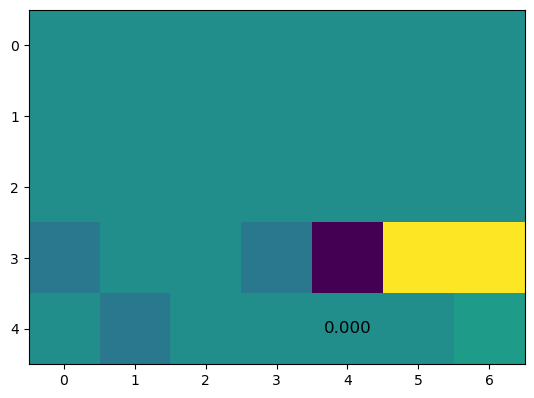

(0, 1)


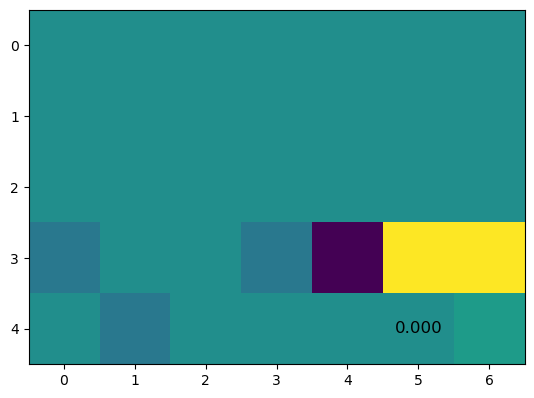

(0, 1)


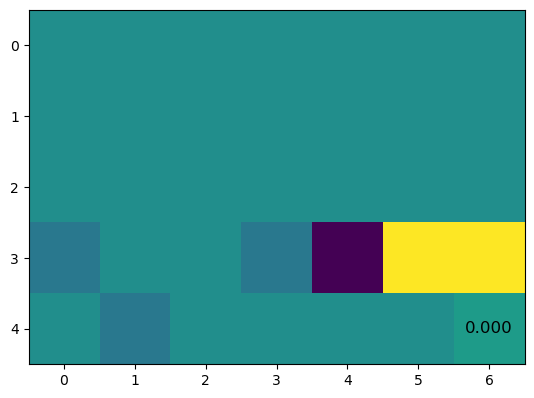

In [8]:
#test walk, 0 = agent

import time

world.reset()
while not world.gameOver():
    act = naive_pi(world)
    print(act)
    world.step(act)
    world.plot({world.getState(): 0})
    time.sleep(.5)

In [40]:
#sample and find MC approx. of V
def MC(epochs):
    V_aggregator = {}

    for i in range(epochs):
        world.reset()
        start = world.getState()
        reward = world.getReward(start)
        while not world.gameOver() and reward > -1:
            reward += world.step(naive_pi(world))

        if start in V_aggregator: 
            V_aggregator[start].append(reward)
        else: 
            V_aggregator[start] = [reward]

    for k,v in V_aggregator.items():
        V_aggregator[k] = np.mean(v)

    return V_aggregator

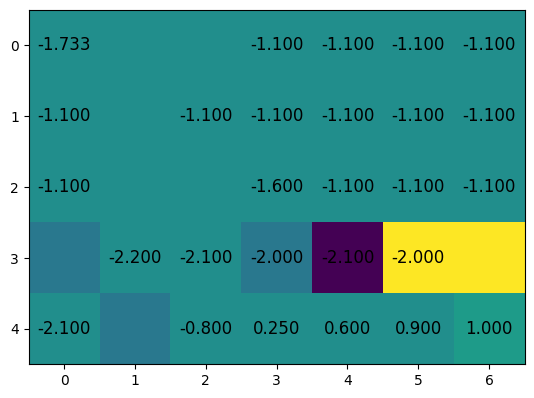

In [41]:
world.plot(MC(50))

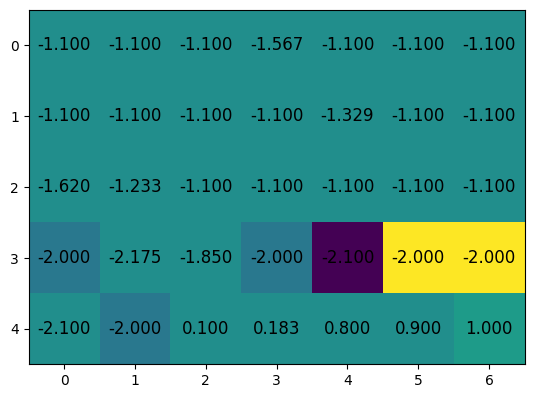

In [42]:
world.plot(MC(200))

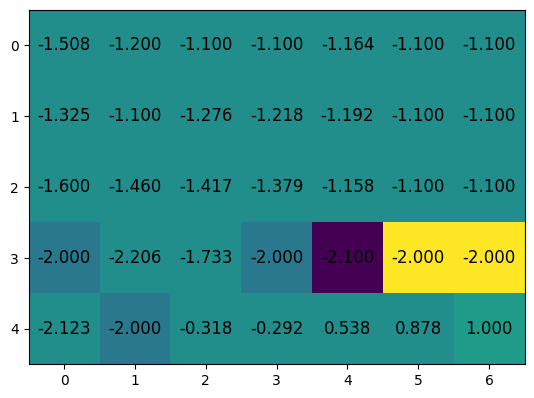

In [43]:
world.plot(MC(500))

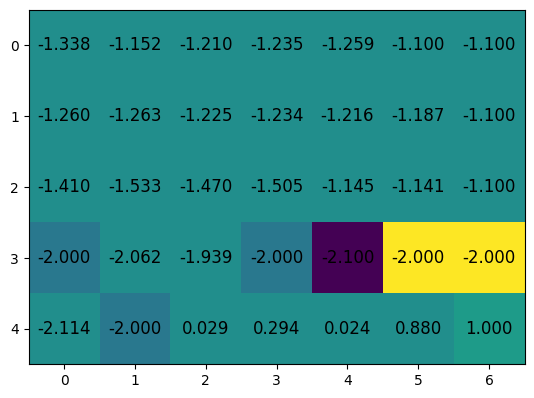

In [44]:
world.plot(MC(1000))

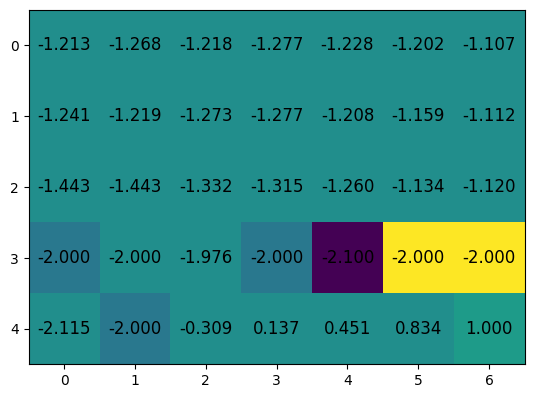

In [45]:
world.plot(MC(10000))

In [1]:
# Homework 2: Implementing MC Policy Iteration with exploring starts

In [35]:
# Initialize random pi
states = world.getStates()
actions = world.getActions()
vals = random.choices(actions, k = len(states))
pi = dict(zip(states, vals))

# Initialize Q randomly
Q = states
Q = dict(list(map(lambda s: (s, dict(list(map(lambda a: (a, random.uniform(-1, 1)), actions)))), Q)))

# Set return accumulator
Returns = states
Returns = dict(list(map(lambda s: (s, dict(list(map(lambda a: (a, []), actions)))), Returns)))

# Metrics
episode_returns = []

#main loop
episodes = 10000
max_steps = 20
gamma = 0.9

for episode in range(episodes):
    # choose random start
    world.reset() 
    start_state = world.getState() # start state automatically chosen randomly
    start_action = random.choice(actions)

    Record_steps = [] # list of rewards of episode
    Record_steps.append((start_state, start_action))
    Record_rewards = []
    Record_rewards.append(world.step(start_action))

    # create episode according to pi
    step_counter = 0
    while not world.gameOver() and step_counter <= max_steps:
        step_counter += 1
        action = pi[world.getState()]
        Record_steps.append((world.getState(), action)) 
        Record_rewards.append(world.step(action))

    episode_returns.append(sum(Record_rewards))
    if(episode % 100 == 0):
        print(np.mean(episode_returns))

    # update Q-value function and pi according to MC-Method
    G = 0
    while Record_steps:
        last_step = Record_steps.pop()
        last_reward = Record_rewards.pop()
        G = gamma*G + last_reward
        if last_step not in Record_steps:
            state, action = last_step
            Returns[state][action].append(G)
            Q[state][action] = np.mean(Returns[state][action])
            pi[state] = max(Q[state], key=Q[state].get)




-2.2000000000000006
-3.6019801980198034
-2.725373134328359
-2.5073089700996682
-2.2715710723192024
-1.97684630738523
-1.7374376039933448
-1.5496433666191158
-1.4002496878901378
-1.272253052164262
-1.1523476523476526
-1.0683015440508634
-1.000666111573689
-0.9346656418139896
-0.8796573875803002
-0.8288474350433046
-0.7790131168019989
-0.7384479717813053
-0.701554691837868
-0.6672803787480276
-0.634632683658171
-0.6090909090909093
-0.5857791912766926
-0.5577140373750546
-0.5345272802998752
-0.5159136345461818
-0.5020376778162247
-0.4869677897075158
-0.46729739378793306
-0.45456739055498113
-0.4441519493502167
-0.43614962915188665
-0.42633552014995324
-0.41084519842471984
-0.4025874742722729
-0.3919165952584977
-0.38094973618439326
-0.3737638476087546
-0.3669560641936334
-0.3560369136118945
-0.34646338415396155
-0.3385271884906121
-0.32980242799333503
-0.3247151825156941
-0.3199954555782778
-0.3149744501221951
-0.3098456857204957
-0.3027653690704106
-0.2971672568214956
-0.2940216282391349

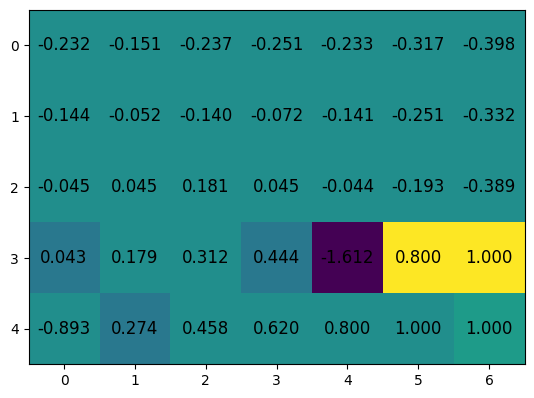

In [50]:
# plot value function
Vals = { state: actions[pi[state]] for state, actions in Q.items() }
world.plot(Vals)

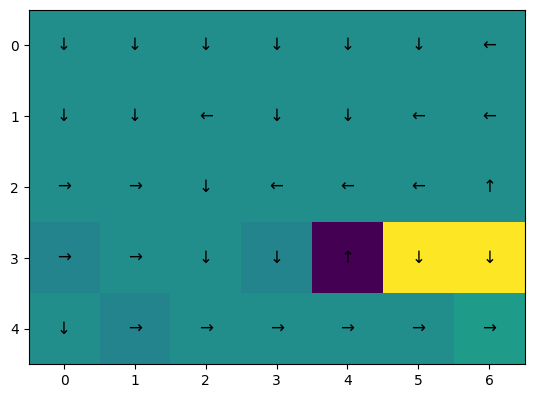

In [61]:
# plot actions
Acts = { state: action_names[action] for state, action in pi.items() }
world.plot(Acts)